In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""Main training script for Cascaded Nets."""
import argparse
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import torch
from collections import defaultdict
from datasets.dataset_handler import DataHandler
from matplotlib.lines import Line2D
from modules import utils
from scipy import interpolate

## Setup Args

In [3]:
def setup_args():
  parser = argparse.ArgumentParser()
  parser.add_argument("--random_seed", type=int, default=42,
                      help="random seed")
  
  # Paths
  parser.add_argument("--experiment_root", type=str, 
                      default='experiments',
                      help="Local output dir")
#   parser.add_argument("--experiment_name", type=str, 
#                       required=True,
#                       help="Experiment name")
  
  # Dataset
#   parser.add_argument("--dataset_root", type=str, required=True,
#                       help="Dataset root")
#   parser.add_argument("--dataset_name", type=str, required=True,
#                       help="Dataset name: CIFAR10, CIFAR100, TinyImageNet")
  parser.add_argument("--split_idxs_root", type=str, default='split_idxs',
                      help="Split idxs root")
  parser.add_argument("--val_split", type=float, default=0.1,
                      help="Validation set split: 0.1 default")
  parser.add_argument("--augmentation_noise_type", type=str, 
                      default='occlusion',
                      help="Augmentation noise type: occlusion")
  parser.add_argument("--batch_size", type=int, default=128,
                      help="batch_size")
  parser.add_argument("--num_workers", type=int, default=2,
                      help="num_workers")
  parser.add_argument('--drop_last', action='store_true', default=False,
                      help='Drop last batch remainder')
  
  # Model
  parser.add_argument("--model_key", type=str, default='resnet18',
                      help="Model: resnet18, resnet34, ..., densenet_cifar")
  parser.add_argument("--train_mode", type=str, 
                      default='baseline',
                      help="Train mode: baseline, ic_only, sdn")
  parser.add_argument('--bn_time_affine', action='store_true', default=False,
                      help='Use temporal affine transforms in BatchNorm')
  parser.add_argument('--bn_time_stats', action='store_true', default=False,
                      help='Use temporal stats in BatchNorm')
  parser.add_argument("--tdl_mode", type=str, 
                      default='OSD',
                      help="TDL mode: OSD, EWS, noise")
  parser.add_argument("--tdl_alpha", type=float, default=0.0,
                      help="TDL alpha for EWS temporal kernel")
  parser.add_argument("--noise_var", type=float, default=0.0,
                      help="Noise variance on noise temporal kernel")
  parser.add_argument("--lambda_val", type=float, default=1.0,
                      help="TD lambda value")
  parser.add_argument('--cascaded', action='store_true', default=False,
                      help='Cascaded net')
  parser.add_argument("--cascaded_scheme", type=str, default='parallel',
                      help="cascaded_scheme: serial, parallel")
  parser.add_argument("--init_tau", type=float, default=0.01,
                      help="Initial tau valu")
  parser.add_argument("--target_IC_inference_costs", nargs="+", type=float, 
                      default=[0.15, 0.30, 0.45, 0.60, 0.75, 0.90],
                      help="target_IC_inference_costs")
  parser.add_argument('--tau_weighted_loss', action='store_true', default=False,
                      help='Use tau weights on IC losses')
  
  
  # Optimizer
  parser.add_argument("--learning_rate", type=float, default=0.1,
                      help="learning rate")
  parser.add_argument("--momentum", type=float, default=0.9,
                      help="momentum")
  parser.add_argument("--weight_decay", type=float, default=0.0005,
                      help="weight_decay")
  parser.add_argument('--nesterov', action='store_true', default=False,
                      help='Nesterov for SGD')
  parser.add_argument('--normalize_loss', action='store_true', default=False,
                      help='Normalize temporal loss')
  
  # LR scheduler
  parser.add_argument("--lr_milestones", nargs="+", type=float, 
                      default=[60, 120, 150],
                      help="lr_milestones")
  parser.add_argument("--lr_schedule_gamma", type=float, default=0.2,
                      help="lr_schedule_gamma")
  
  # Other
  parser.add_argument('--use_cpu', action='store_true', default=False,
                      help='Use cpu')
  parser.add_argument("--device", type=int, default=0,
                      help="GPU device num")
  parser.add_argument("--n_epochs", type=int, default=150,
                      help="Number of epochs to train")
  parser.add_argument("--eval_freq", type=int, default=10,
                      help="eval_freq")
  parser.add_argument("--save_freq", type=int, default=5,
                      help="save_freq")
  parser.add_argument('--keep_logits', action='store_true', default=False,
                      help='Keep logits')
  parser.add_argument('--debug', action='store_true', default=False,
                      help='Debug mode')
  
  args = parser.parse_args("")
  
  # Flag check
  if args.tdl_mode == 'EWS':
    assert args.tdl_alpha is not None, 'tdl_alpha not set'
  elif args.tdl_mode == 'noise':
    assert args.noise_var is not None, 'noise_var not set'
    
  return args

In [4]:
args = setup_args()

## Override Args

In [5]:
args.dataset_root = "/scratch/work/public/imagenet" 
args.experiment_root = "/scratch/sbp354/cascade_output/experiments" 
args.split_idxs_root = "/scratch/sbp354/cascade_output/split_idx"
  
# Set required flags|
args.dataset_name = 'ImageNet2012_16classes'  # CIFAR10, CIFAR100, ImageNet2012
args.model_key = 'resnet18'
args.dataset_key = 'test'  # val, test
if args.dataset_name == "ImageNet2012_16classes":
  args.experiment_name = f"{args.model_key}_{args.dataset_name}"
elif "cifar" in args.dataset_name.lower():
  args.experiment_name = f"{args.model_key}_{args.dataset_name}"
else:
  print("TinyImageNet not implemented yet!")
  
args.val_split = 0.1
args.test_split = 0.1
args.tdl_mode = 'OSD'  # OSD, EWS
args.tau_weighted_loss = True
args.random_seed = 42
args.grayscale = False

In [6]:
# Make reproducible
utils.make_reproducible(args.random_seed)

Making reproducible on seed 42


## Setup Figs Dir

In [7]:
figs_root = 'figs'
if not os.path.exists(figs_root):
  os.makedirs(figs_root)
  
fig_path = os.path.join(figs_root, f'{args.dataset_name}.pdf')
fig_path

'figs/ImageNet2012_16classes.pdf'

## Model Label Lookup

In [8]:
MODEL_LBL_LOOKUP = {
    "cascaded__serial": "SerialTD",
    "cascaded__parallel": "CascadedTD",
    "cascaded__serial__multiple_fcs": "SerialTD-MultiHead",  # (SDN)
    "cascaded__parallel__multiple_fcs": "CascadedTD-MultiHead",
    "cascaded_seq__serial": "SerialCE",
    "cascaded_seq__parallel": "CascadedCE",
}

## Colors

In [9]:
colors_src = {
    "CascadedTDColor": np.array([182,54,121]) / 255.0,  # CascadedTDColor,
    "CascadedCEColor": np.array([127,38,110]) / 255.0,  # CascadedCEColor,
    "SerialTDColor": np.array([77,184,255]) / 255.0,  # SerialTDColor,
    "SerialCEColor": np.array([54,129,179]) / 255.0,  # SerialCEColor,
}

model_colors = {
    "cascaded__serial": colors_src["SerialTDColor"],
    "cascaded__parallel": colors_src["CascadedTDColor"],
    "cascaded__serial__multiple_fcs": colors_src["SerialTDColor"],  # (SDN)
    "cascaded__parallel__multiple_fcs": colors_src["CascadedTDColor"],
    "cascaded_seq__serial": colors_src["SerialCEColor"],
    "cascaded_seq__parallel": colors_src["CascadedCEColor"],
}

## Setup Data Handler

In [10]:
# Data Handler
data_dict = {
    "dataset_name": args.dataset_name,
    "experiment_root":args.experiment_root,
    "data_root": args.dataset_root,
    "val_split": args.val_split,
    "test_split": args.test_split,
    "split_idxs_root": args.split_idxs_root,
    "noise_type": args.augmentation_noise_type,
    "load_previous_splits": True,
    "grayscale": False,
    "imagenet_params": {
      #"target_classes": ["terrier"],
      "max_classes": 1000,
    }
}
data_handler = DataHandler(**data_dict)

Setting split idxs root to /scratch/sbp354/cascade_output/split_idx/ImageNet2012_16classes
EXPERIMENT_ROOT /scratch/sbp354/cascade_output/experiments
Loading data from /scratch/sbp354/cascade_output/experiments
number of classes 16
Fin.
['n02814533', 'n03100240', 'n04285008', 'n02132136', 'n02133161', 'n02134084', 'n02134418', 'n02085782', 'n02085936', 'n02086079', 'n02086240', 'n02086646', 'n02086910', 'n02087046', 'n02087394', 'n02088094', 'n02088238', 'n02088364', 'n02088466', 'n02088632', 'n02089078', 'n02089867', 'n02089973', 'n02090379', 'n02090622', 'n02090721', 'n02091032', 'n02091134', 'n02091244', 'n02091467', 'n02091635', 'n02091831', 'n02092002', 'n02092339', 'n02093256', 'n02093428', 'n02093647', 'n02093754', 'n02093859', 'n02093991', 'n02094114', 'n02094258', 'n02094433', 'n02095314', 'n02095570', 'n02095889', 'n02096051', 'n02096294', 'n02096437', 'n02096585', 'n02097047', 'n02097130', 'n02097209', 'n02097298', 'n02097474', 'n02097658', 'n02098105', 'n02098286', 'n020992

In [11]:
# Set Loaders
test_loader = data_handler.build_loader(args.dataset_key, args)

DATASET_SRC <datasets.imagenet2012_handler.ImagenetDataset object at 0x7f69c2592430>


## Load Experiment Data

In [21]:
# Set experiment root
exp_root = os.path.join(args.experiment_root,
                        args.experiment_name,
                        'experiments')
print(exp_root)

#exp_root = f"/hdd/mliuzzolino/cascaded_nets/{args.experiment_name}/experiments"
            

# Find exp paths
exp_paths = [i for i in np.sort(glob.glob(f'{exp_root}/*/outputs/*__{args.dataset_key}__{args.tdl_mode}.pt'))\
            if str.find(i, "grayscale")>-1]
exp_paths_seq = [i for i in np.sort(glob.glob(f'{exp_root}/*/outputs/*__{args.dataset_key}__{args.tdl_mode}.pt'))\
            if str.find(i, "_seq")>-1]
exp_paths.append(exp_paths_seq)
exp_paths = np.array(exp_paths)
print(f"Num paths: {len(exp_paths)}")
for path in exp_paths:
    print(path)

/scratch/sbp354/cascade_output/experiments/resnet18_ImageNet2012_16classes/experiments
Num paths: 5
/scratch/sbp354/cascade_output/experiments/resnet18_ImageNet2012_16classes/experiments/td(0.0),parallel,lr_0.01,wd_0.0005,seed_42,grayscale/outputs/output_representations__test__OSD.pt
/scratch/sbp354/cascade_output/experiments/resnet18_ImageNet2012_16classes/experiments/td(0.0),parallel,lr_0.01,wd_0.0005,seed_42,multiple_fcs,grayscale/outputs/output_representations__test__OSD.pt
/scratch/sbp354/cascade_output/experiments/resnet18_ImageNet2012_16classes/experiments/td(1.0),serial,lr_0.01,wd_0.0005,seed_42,grayscale/outputs/output_representations__test__OSD.pt
/scratch/sbp354/cascade_output/experiments/resnet18_ImageNet2012_16classes/experiments/td(1.0),serial,lr_0.01,wd_0.0005,seed_42,multiple_fcs,grayscale/outputs/output_representations__test__OSD.pt
['/scratch/sbp354/cascade_output/experiments/resnet18_ImageNet2012_16classes/experiments/cascaded_seq__parallel,lr_0.01,wd_0.0005,seed_542

/tmp/ipykernel_2668710/715224491.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  exp_paths = np.array(exp_paths)


#### Build Dataframe

In [22]:
df_dict = defaultdict(list)
outrep_id = 0
outreps_dict = {}
ic_costs_lookup = {}
exp_path_lookup = {}
for i, exp_path in enumerate(exp_paths):
  outrep_id = f'rep_id_{i}'
  outrep = torch.load(exp_path)
  
  basename = [ele for ele in exp_path.split(os.path.sep) if 'seed_' in ele][0]
  keys = basename.split(',')
  print(keys)
  if keys[0].startswith('std') or keys[0].startswith('cascaded_seq'):
    model_key, lr, weight_decay, seed = keys
    td_key = 'std'
  else:
    td_key, scheme_key, lr, weight_decay, seed = keys[:5]
    model_key = f'cascaded__{scheme_key}'
    other_keys = keys[5:]
    multiple_fcs = 'multiple_fcs' in other_keys
    tau_weighted = 'tau_weighted' in other_keys
    pretrained_weights = 'pretrained_weights' in other_keys
    if multiple_fcs:
      model_key = f'{model_key}__multiple_fcs'
    if tau_weighted:
      model_key = f'{model_key}__tau_weighted'
    if pretrained_weights:
      model_key = f'{model_key}__pretrained_weights'

  if model_key != 'std':
    exp_root = os.path.dirname(os.path.dirname(exp_path))
    IC_cost_path = os.path.join(exp_root, 'ic_costs.pt')
    if os.path.exists(IC_cost_path):
      IC_costs = torch.load(IC_cost_path)
    else:
      IC_costs = None
  else:
    IC_costs = None
    
  lr = float(lr.split("_")[1])
  weight_decay = float(weight_decay.split("_")[1])
  print(model_key)
  df_dict['model'].append(model_key)
  df_dict['td_lambda'].append(td_key)
  df_dict['lr'].append(lr)
  df_dict['weight_decay'].append(weight_decay)
  df_dict['seed'].append(seed)
  df_dict['outrep_id'].append(outrep_id)
  

  outreps_dict[outrep_id] = outrep
  ic_costs_lookup[outrep_id] = IC_costs
  exp_path_lookup[outrep_id] = exp_path
analysis_df = pd.DataFrame(df_dict)

['td(0.0)', 'parallel', 'lr_0.01', 'wd_0.0005', 'seed_42', 'grayscale']
cascaded__parallel
['td(0.0)', 'parallel', 'lr_0.01', 'wd_0.0005', 'seed_42', 'multiple_fcs', 'grayscale']
cascaded__parallel__multiple_fcs
['td(1.0)', 'serial', 'lr_0.01', 'wd_0.0005', 'seed_42', 'grayscale']
cascaded__serial
['td(1.0)', 'serial', 'lr_0.01', 'wd_0.0005', 'seed_42', 'multiple_fcs', 'grayscale']
cascaded__serial__multiple_fcs


AttributeError: 'list' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

## Build Aggregate Stats

In [18]:
df_dict = defaultdict(list)
analysis_df = analysis_df.sort_values('model')
for i, df_i in analysis_df.iterrows():
  outrep_i = outreps_dict[df_i.outrep_id]
  accs = outrep_i['correct'].float().mean(dim=1)
  
  for i, acc in enumerate(accs):
    df_dict['acc'].append(acc.item() * 100)
    if len(accs) == 1:
      i = -1
    df_dict['ic'].append(i)
    for k in list(df_i.index):
      df_dict[k].append(df_i[k])
accs_df = pd.DataFrame(df_dict)

In [19]:
accs_df = accs_df.sort_values(['outrep_id', 'ic'])

df_dict = defaultdict(list)
for model_key, model_df in accs_df.groupby('model'):
  for td_lambda, lambda_df in model_df.groupby('td_lambda'):
    for ic, ic_df in lambda_df.groupby('ic'):
      mean_acc = np.mean(ic_df.acc)
      sem_acc = np.std(ic_df.acc) / np.sqrt(len(ic_df.acc))
      outrep_id = ic_df.outrep_id.iloc[0]
      df_dict['model'].append(model_key)
      df_dict['td_lambda'].append(td_lambda)
      df_dict['ic'].append(ic)
      df_dict['acc'].append(mean_acc)
      df_dict['sem'].append(sem_acc)
      df_dict['outrep_id'].append(outrep_id)
      
      flops = ic_costs_lookup[outrep_id]
      if flops is not None:
        try:
          flops = flops['flops'][ic]
        except:
          flops = 1.0
      df_dict['flops'].append(flops)
stats_df = pd.DataFrame(df_dict)
stats_df.loc[stats_df.ic==-1, 'ic'] = np.max(stats_df.ic)
stats_df.ic = [ele+1 for ele in stats_df.ic]

## Accuracy vs. TD($\lambda$) Curves

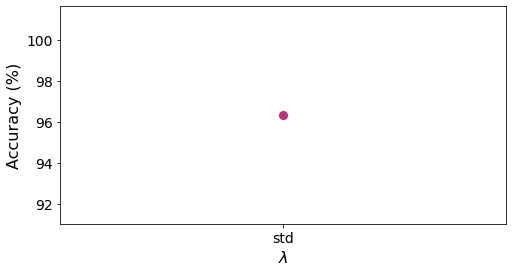

In [20]:
color = np.array([182,54,121]) / 255.0

AXIS_LBL_FONTSIZE = 16
LEGEND_FONTSIZE = 16
TICK_FONTSIZE = 14
FIGSIZE = (8,4) # (12,5)

plt.figure(figsize=FIGSIZE)
g = sns.lineplot(
    x="td_lambda", 
    y="acc", 
    data=model_df,
    lw=6,
    color=color,
)
g = sns.scatterplot(
    x="td_lambda", 
    y="acc", 
    data=model_df,
    s=100,
    color=color,
)
g.set_xticks(model_df.td_lambda.unique())
g.set_xlabel(r"$\lambda$", fontsize=AXIS_LBL_FONTSIZE)
g.set_ylabel("Accuracy (%)", fontsize=AXIS_LBL_FONTSIZE)
g.tick_params(axis='x', labelsize=TICK_FONTSIZE)
g.tick_params(axis='y', labelsize=TICK_FONTSIZE)
save_path = os.path.join("figs", f"{args.dataset_name}__td_curves.pdf")
plt.savefig(save_path, dpi=300)
plt.savefig(save_path.replace(".pdf", ".png"), dpi=300)

# Compute Speed Accuracy Tradeoff

In [21]:
def compute_threshold_conf_correct(pred_conf, correct, q):
  correct_arr = []
  best_clf_idxs = []
  n_clfs = pred_conf.shape[0]
  n_samples = pred_conf.shape[1]
  for i in range(n_samples):
    pred_conf_i = pred_conf[:,i]
    idxs = np.where(pred_conf_i >= q)[0]
    if not len(idxs):
      best_clf_idx = n_clfs - 1
      cor_i = correct[best_clf_idx,i]
    else:
      best_clf_idx = idxs[0]
      cor_i = correct[best_clf_idx,i]
    correct_arr.append(cor_i)
    best_clf_idxs.append(best_clf_idx)
  avg_acc = np.mean(correct_arr)
  return avg_acc, best_clf_idxs

In [22]:
df_dict = defaultdict(list)
for model_key, model_df in analysis_df.groupby('model'):
  print(model_key)
  if model_key == 'cascaded_seq__serial':
    delta = 100
  else:
    delta = 100
  Qs = np.linspace(0, 1, delta)
  
  if model_key in ['std']:
    continue
    
  print(f"\nModel: {model_key}")
  for td_lambda, td_df in model_df.groupby('td_lambda'):
    for jj, df_i in td_df.iterrows():
      outrep_id = df_i.outrep_id
      outrep_i = outreps_dict[outrep_id]
      try:
        flop_costs = ic_costs_lookup[outrep_id]['flops']
      except:
        for k, v in ic_costs_lookup.items():
          if v is not None:
            flop_costs = v['flops']
            break
      
      #f_interpolate = interpolate.interp1d(range(len(flop_costs)), flop_costs, bounds_error=False)

      prediction_confidence = outrep_i['prediction_confidence']
      correct_vals = outrep_i['correct']

      accs = []
      flops = []
      for qi, q in enumerate(Qs):
        sys.stdout.write((f'\rTD_lambda: {td_lambda} -- '
                          f'df_{jj} [{jj+1}/{len(td_df)}] -- '
                          f'Threshold, q: {q:0.2f} [{qi+1}/{len(Qs)}]'))
        sys.stdout.flush()
        acc_i, best_clf_idxs = compute_threshold_conf_correct(prediction_confidence, correct_vals, q)
        avg_timesteps = np.mean(best_clf_idxs)
        #avg_flop = f_interpolate(avg_timesteps)
        
        #flops.append(avg_flop)
        df_dict['model'].append(model_key)
        df_dict['td_lambda'].append(td_lambda)
        df_dict['seed'].append(df_i.seed)
        df_dict['acc'].append(acc_i * 100)
        #df_dict['flops'].append(avg_flop)
        df_dict['timesteps'].append(avg_timesteps)
        df_dict['q'].append(q)
      print("\n")
speed_acc_data_df = pd.DataFrame(df_dict)

cascaded__parallel

Model: cascaded__parallel
TD_lambda: td(0.0) -- df_4 [5/1] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(0.5) -- df_8 [9/1] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(1.0) -- df_10 [11/1] -- Threshold, q: 1.00 [100/100]

cascaded__parallel__multiple_fcs

Model: cascaded__parallel__multiple_fcs
TD_lambda: td(0.0) -- df_3 [4/1] -- Threshold, q: 1.00 [100/100]

cascaded__serial

Model: cascaded__serial
TD_lambda: td(0.0) -- df_6 [7/1] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(0.25) -- df_7 [8/1] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(0.5) -- df_9 [10/1] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(1.0) -- df_12 [13/1] -- Threshold, q: 1.00 [100/100]

cascaded__serial__multiple_fcs

Model: cascaded__serial__multiple_fcs
TD_lambda: td(0.0) -- df_5 [6/1] -- Threshold, q: 1.00 [100/100]

TD_lambda: td(1.0) -- df_11 [12/1] -- Threshold, q: 1.00 [100/100]

cascaded_seq__parallel

Model: cascaded_seq__parallel
TD_lambda: std -- df_0 [1/1] -- Threshold, q: 

### Agg Stats

In [23]:
def fix_df(df_src, fix_key='cascaded_seq__serial'):
  df_src = df_src.copy()
  df = df_src[df_src.model==fix_key]
  df = df.sort_values('timestep_mean')
  prev_j = None
  for i, j in df.iterrows():
    if j.timestep_mean != 0.0:
      break
    prev_j = j

  for t in np.linspace(prev_j.timestep_mean, j.timestep_mean, 10)[:-1]:
    new_j = prev_j.copy()
    new_j.timestep_mean = t
    new_j.timestep_mean = t
    df = df.append(new_j, ignore_index=True)
  df = df.sort_values('timestep_mean')
  df_src.drop(df_src[df_src.model==fix_key].index, inplace=True)
  df_src = pd.concat([df_src, df])
  return df_src

In [24]:
single_seed = None

df_dict = defaultdict(list)
for model_key, model_df in speed_acc_data_df.groupby('model'):
  for td_lambda, td_df in model_df.groupby('td_lambda'):
    for q, q_df in td_df.groupby('q'):
      if single_seed is not None:
        q_df = q_df[q_df.seed.str.contains(f"_{single_seed}")]
      acc_mean = np.mean(q_df.acc)
      n = len(q_df)
      acc_sem = np.std(q_df.acc) / np.sqrt(n)
      timestep_mean = np.mean(q_df.timesteps)
      timestep_sem = np.std(q_df.timesteps) / np.sqrt(n)

      df_dict['model'].append(model_key)
      df_dict['q'].append(q)
      df_dict['acc_mean'].append(acc_mean)
      df_dict['acc_sem'].append(acc_sem)
      df_dict['timestep_mean'].append(timestep_mean)
      df_dict['timestep_sem'].append(timestep_sem)
      df_dict['td_lambda'].append(td_lambda)
      df_dict['n'].append(n)
q_stat_df = pd.DataFrame(df_dict)

try:
  q_stat_df = fix_df(q_stat_df, 'cascaded_seq__serial')
except:
  print("Exception!")

## Speed Accuracy Tradeoff Curves

In [25]:
print(stats_df.model.unique())

['cascaded__parallel' 'cascaded__parallel__multiple_fcs'
 'cascaded__serial' 'cascaded__serial__multiple_fcs'
 'cascaded_seq__parallel' 'cascaded_seq__serial' 'std']


In [26]:
def compute_best_lambdas(stats_df, sdn_TD1=True):
  best_lambdas = {}
  for model_key, model_df in stats_df.groupby('model'):
    model_df = model_df[model_df.ic==model_df.ic.max()] 
    model_df = model_df[model_df.acc==model_df.acc.max()]
    best_lambda = model_df.iloc[0].td_lambda
    if sdn_TD1:
      if 'cascaded__serial' in model_key:
        best_lambdas[model_key] = 'td(1.0)'
      elif 'cascaded__parallel' in model_key:
        best_lambdas[model_key] = 'td(0.0)'
      else:
        best_lambdas[model_key] = best_lambda
    else:
      best_lambdas[model_key] = best_lambda
  return best_lambdas

In [27]:
def fix_legend_order(handles, labels):
  order = [
      'CascadedTD', 
      'CascadedTD-MultiHead', 
      'CascadedCE',
      'SerialTD', 
      'SerialTD-MultiHead', 
      'SerialCE',
  ]
  idxs = []
  for key in order:
    if key in labels:
      idx = labels.index(key)
      idxs.append(idx)
  handles = list(np.array(handles)[idxs])
  labels = list(np.array(labels)[idxs])
  return handles, labels

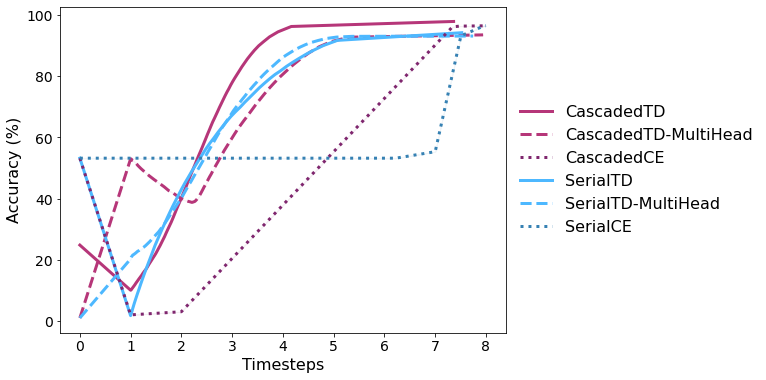

In [28]:
SHOW_EBARS = True
LINEWIDTH = 3
AXIS_LBL_FONTSIZE = 16
LEGEND_FONTSIZE = 16
TICK_FONTSIZE = 14
fig = plt.figure(figsize=(8,6))

# Compute best lambdas
best_lambdas = compute_best_lambdas(stats_df)

y_dfs = []
for model_key, model_df in q_stat_df.groupby('model'):
  best_lambda = best_lambdas[model_key]
  model_df = model_df[model_df.td_lambda==best_lambda]
  y_dfs.append(model_df)
q_stat_df_fixed = pd.concat(y_dfs)

max_flop = np.max(q_stat_df_fixed.timestep_mean)

for i, (model_key, model_df) in enumerate(q_stat_df_fixed.groupby('model')):
  linestyle = '--' if 'multiple_fcs' in model_key else '-'
  if 'cascaded_seq' in model_key:
    linestyle = 'dotted'
  try:
    color_i = model_colors[model_key]
  except:
    color_i = model_colors["cascaded__parallel__multiple_fcs"]
  
  timestep_vals = np.array(list(model_df.timestep_mean))
  
  sorted_idxs = np.argsort(timestep_vals)
  timestep_vals = timestep_vals[sorted_idxs]
  acc_vals = np.array(list(model_df.acc_mean))[sorted_idxs]
  sem_error = np.array(list(model_df.acc_sem))[sorted_idxs]
    
  td_lambda_lbl = model_df.iloc[0].td_lambda.replace('td(', 'TD(')
  try:
    label = MODEL_LBL_LOOKUP[model_key]
  except:
    label = "cascaded__scheme_1__multiple_fcs"
  plt.plot(timestep_vals, acc_vals, label=label, 
           linewidth=LINEWIDTH, c=color_i, linestyle=linestyle)
  
  if SHOW_EBARS:
    lower_b = np.array(acc_vals) - np.array(sem_error)
    upper_b = np.array(acc_vals) + np.array(sem_error)
    plt.fill_between(timestep_vals, lower_b, upper_b, alpha=0.075, color=color_i)
  
plt.xlabel('Timesteps', fontsize=AXIS_LBL_FONTSIZE)
plt.ylabel('Accuracy (%)', fontsize=AXIS_LBL_FONTSIZE)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
handles, labels = ax.get_legend_handles_labels()
handles, labels = fix_legend_order(handles, labels)
ax.legend(handles=handles, labels=labels)
                   
final_fig_path = fig_path
if 'metacog_df' in globals() and _SHOW_METACOG:
  final_fig_path = final_fig_path.replace('.pdf', '_with_metacog.pdf')
  metacog_df = metacog_df.sort_values('mean_time')
  metacog_time = metacog_df.mean_time
  metacog_acc = metacog_df.mean_correct * 100
  metacog_color = np.array((255, 148, 77)) / 255.
  metacog_ls = (0, (3, 1, 1, 1))
  plt.plot(metacog_time, metacog_acc, 
           linewidth=LINEWIDTH, color=metacog_color, linestyle=metacog_ls)
  metacog_patch = Line2D([0], [0], color=metacog_color, lw=LINEWIDTH, 
                         linestyle=metacog_ls, label='MetaCog GRU-RNN')

  handles += [metacog_patch]

legend = ax.legend(handles=handles, frameon=False, loc='center left', 
                   bbox_to_anchor=(1., 0.5), prop={'size': LEGEND_FONTSIZE})
fig.subplots_adjust(right=0.9)
  
plt.savefig(final_fig_path, dpi=300, bbox_inches='tight')
plt.savefig(final_fig_path.replace('pdf', 'png'), dpi=300, bbox_inches='tight')

### Print Stats

In [ ]:
for i, (model_key, model_df) in enumerate(q_stat_df_fixed.groupby('model')):
  label = MODEL_LBL_LOOKUP[model_key]
  final_df = model_df[model_df.timestep_mean==model_df.timestep_mean.max()].iloc[0]
  acc = final_df.acc_mean
  sem = final_df.acc_sem
  print(f"{label}: {acc:0.2f}% +/- {sem:0.2f} (n={final_df.n})")
  
  xp = list(model_df.acc_mean)
  fp = list(model_df.timestep_mean)
  t_for_50_perc = np.interp(50, xp, fp)
  print(f"{label}: 50% accuracy @ timestep {t_for_50_perc:0.2f}")
  print("\n")